In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from diffusion_map import *
from utils import read_text

%reload_ext autoreload
%autoreload 2

In [2]:
# Declare constants
N = 1000
pi = np.pi

In [3]:
def part_1():
    """
    Function to simulate task 1. First, generates dataset then applies diffusion map algorithm, 
    and finally plots the eigenfunctions agains time interval.
    """
    def generate_dataset():
        """
        Generates dataset for part 1.
        X = {xk ∈ R^2} k=1->N, xk = (cos(tk),sin(tk)), tk = (2πk)/(N + 1)

        Returns t_k (time) and X (dataset itself)
        """
        t_k = np.array([(2 * pi * k)/(N+1) for k in range(1, N+1)])
        X = np.array([(np.cos(each_t), np.sin(each_t)) for each_t in t_k])
        return t_k, X

    time, dataset = generate_dataset()

    # instantiate diffusion map with the dataset generated above
    # since we need 5 eigenfunctions, L = 4 so that L+1=5
    diffusion_map = DiffusionMap(data=dataset, L=4)

    figure, axis = plt.subplots(1, 5, figsize=(24, 7))

    count = 0
    for each_eigenvector in diffusion_map.final_eigenvectors:
        axis[count].plot(time, each_eigenvector, c=np.random.rand(3,))
        axis[count].set_xlabel('t_k')
        axis[count].set_ylabel('ϕl(x_k')
        axis[count].set_title(f'{count+1} th largest eigenfunction')
        count += 1
    plt.show()

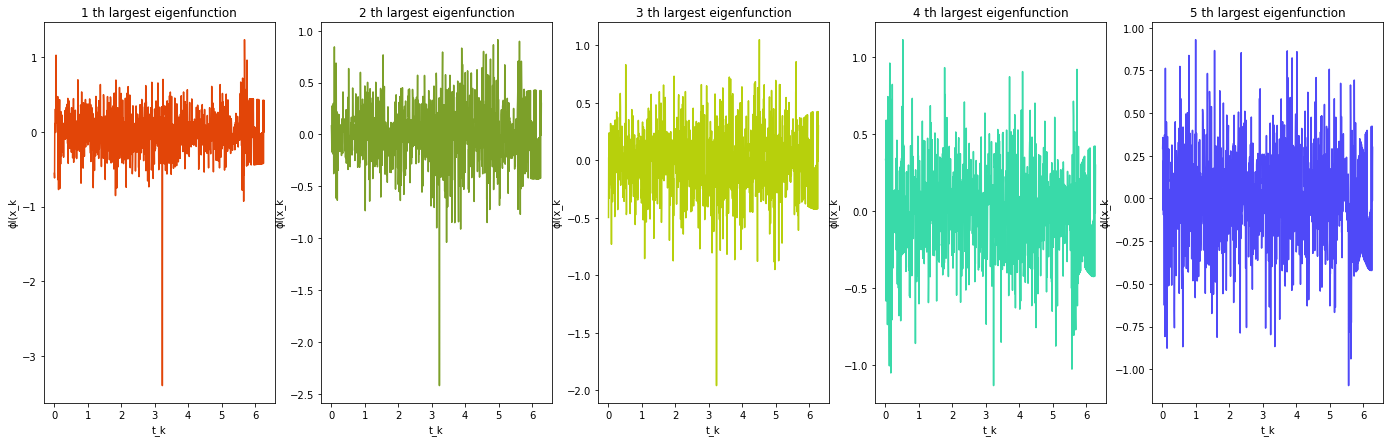

In [4]:
# simulate part 1
part_1()

In [5]:
def generate_swiss_roll_manifold():
    """
    Generates Swiss-Roll manifold then returns. Will be used for two separate sections.

    :returns: (X, t) where X is the data itself and t 
        is the univariate position of the sample according to the main dimension of the points in the manifold.
    """
    X, t = datasets.make_swiss_roll(n_samples=5000)
    return X, t

In [6]:
def visualize_eigenfunctions(diffusion_map):
    """
    Function to visualize eigenvectors on 2-D, for part 2 and 3. There will be 10 plots.
    """
    figure, axis = plt.subplots(2, 5, figsize=(24, 12))
    count = 0
    first_eigenfunction = diffusion_map.final_eigenvectors[0]
    for each_eigenvector in diffusion_map.final_eigenvectors[1:]:
        axis[count // 5][count % 5].plot(first_eigenfunction, each_eigenvector, c=np.random.rand(3,))
        axis[count // 5][count % 5].set_xlabel('First Eigenfunction ϕ_1')
        axis[count // 5][count % 5].set_ylabel(f'Other Eigenfunction ϕ_{count+2}')
        axis[count // 5][count % 5].set_title(f'Eigenfunction comparison')
        count += 1
    plt.show()

In [7]:
def part_2():
    def visualize_swiss_roll_data_3d(data):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        fig.add_axes(ax)
        ax.scatter(
            data[:, 0], data[:, 1], data[:, 2], c=t, s=50, alpha=0.8
        )
        ax.set_title("Swiss-Roll")
        _ = ax.text2D(0.8, 0.05, s="N=5000", transform=ax.transAxes)
        
    swiss_roll_dataset, t = generate_swiss_roll_manifold()
    visualize_swiss_roll_data_3d(swiss_roll_dataset)
    # find first 11 eigenfunctions. compare them against the first(largest) one.
    diffusion_map = DiffusionMap(data=swiss_roll_dataset, L=10)
    visualize_eigenfunctions(diffusion_map)

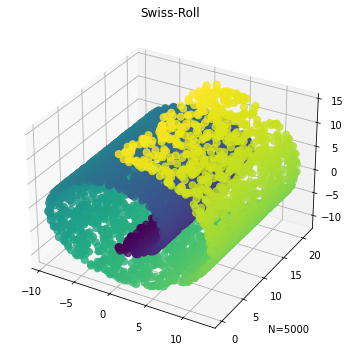

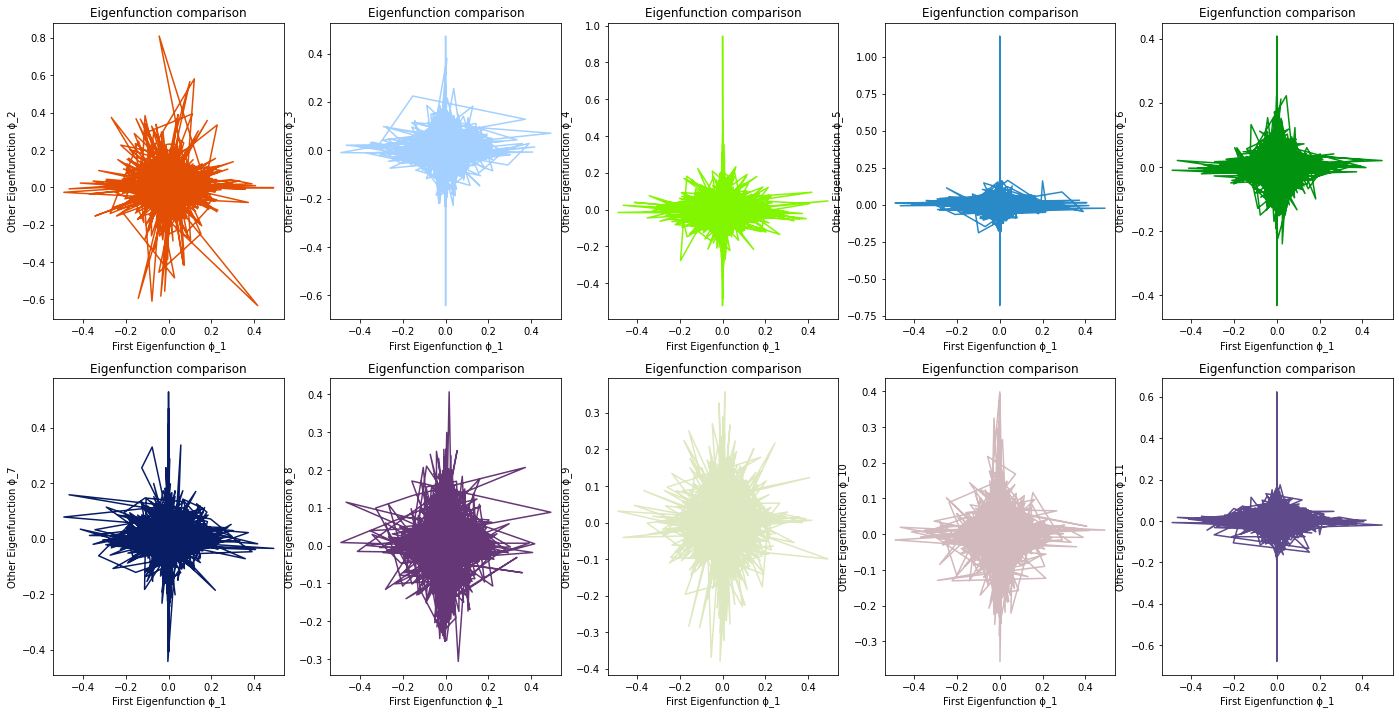

In [8]:
# simulate part 2
part_2()

# Compute the three principal components of the swiss-roll dataset 

In [9]:
%cd ../task_1/
from custom_pca import CustomPCA
%cd ../task_2/

X, t = generate_swiss_roll_manifold()
pca = CustomPCA(X)

# total importance of first 3 components
importance = pca.get_importance_of_first_k(3)

for i in range(3):
    importance = pca.get_importance_of_k(i)
    print('Principal component {} has importance {}'.format(i, importance))

/Users/turkuaz/Desktop/TUM/1.2/IN2106 - ML in Crowd Modeling & Simulation/ml-in-crowd-modeling/exercise_4/task_1
/Users/turkuaz/Desktop/TUM/1.2/IN2106 - ML in Crowd Modeling & Simulation/ml-in-crowd-modeling/exercise_4/task_2
Diagonal matrix values: [501.67028943 451.10797478 428.78948873]
Principal component 0 has importance 39.38349171907012
Principal component 1 has importance 31.84479550537165
Principal component 2 has importance 28.771712775558235


# Datafold

In [10]:
def process_via_datafold():
    """
    Function to re-do the task with datafold library.
    """
    
    import datafold
    import copy

    import matplotlib.pyplot as plt
    import mpl_toolkits.mplot3d.axes3d as p3
    import numpy as np
    import sklearn.manifold as manifold
    from sklearn.datasets import make_swiss_roll
    from sklearn.decomposition import PCA

    import datafold.dynfold as dfold
    import datafold.pcfold as pfold
    import scipy.sparse.linalg
    from datafold.dynfold import LocalRegressionSelection
    from datafold.utils.plot import plot_pairwise_eigenvector
    
    
    nr_samples = 5000
    # reduce number of points for plotting
    nr_samples_plot = 5000
    idx_plot = np.random.permutation(nr_samples)[0:nr_samples_plot]

    # generate point cloud
    X, X_color = make_swiss_roll(nr_samples, noise=0)

    def plot_swiss_roll():
        # plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            X[idx_plot, 0],
            X[idx_plot, 1],
            X[idx_plot, 2],
            c=X_color[idx_plot],
            cmap=plt.cm.Spectral,
        )
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title("point cloud on swiss-roll manifold")
        ax.view_init(10, 70)
        
    def compute_and_plot_diff_map():
        """
        Function to compute eigenvectors and plot eigenfunctions against ϕ_1
        """
        X_pcm = pfold.PCManifold(X)
        X_pcm.optimize_parameters()

        dmap = dfold.DiffusionMaps(
            kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
            n_eigenpairs=9,
            dist_kwargs=dict(cut_off=X_pcm.cut_off),
        )
        dmap = dmap.fit(X_pcm)
        evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

        plot_pairwise_eigenvector(
            eigenvectors=dmap.eigenvectors_[idx_plot, :],
            n=1,
            fig_params=dict(figsize=[15, 15]),
            scatter_params=dict(cmap=plt.cm.Spectral, c=X_color[idx_plot]),
        )
        
        return dmap
    
    def automatic_embedding(dmap):
        selection = LocalRegressionSelection(
            intrinsic_dim=2, n_subsample=500, strategy="dim"
        ).fit(dmap.eigenvectors_)

        target_mapping = selection.transform(dmap.eigenvectors_)

        f, ax = plt.subplots(figsize=(15, 9))
        ax.scatter(
            target_mapping[idx_plot, 0],
            target_mapping[idx_plot, 1],
            c=X_color[idx_plot],
            cmap=plt.cm.Spectral,
        );
    plot_swiss_roll()
    dmap = compute_and_plot_diff_map()
    automatic_embedding(dmap)

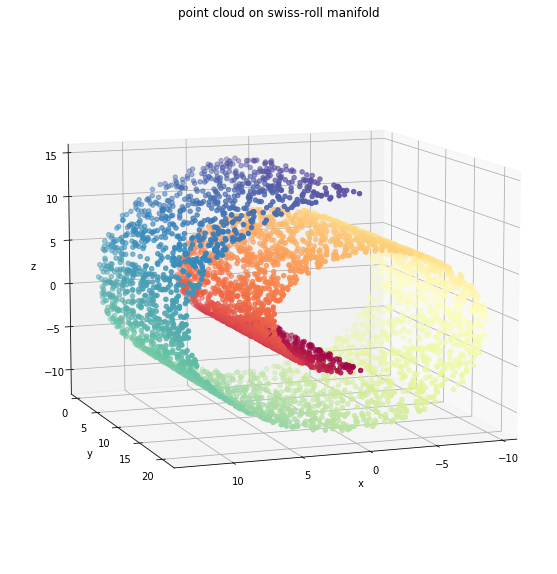

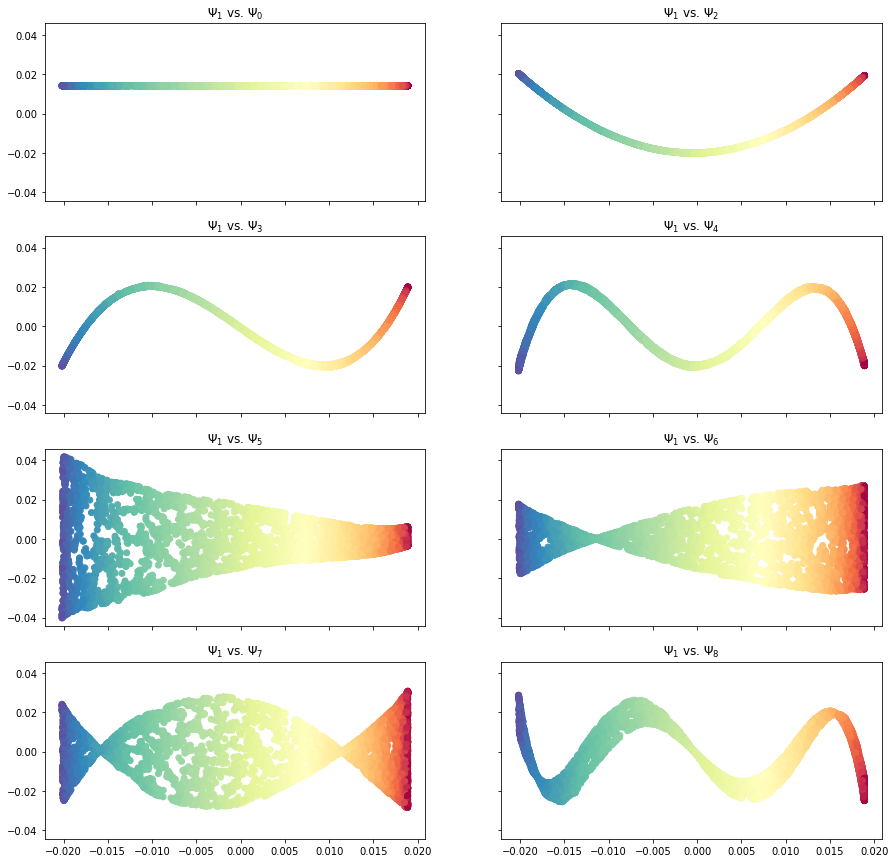

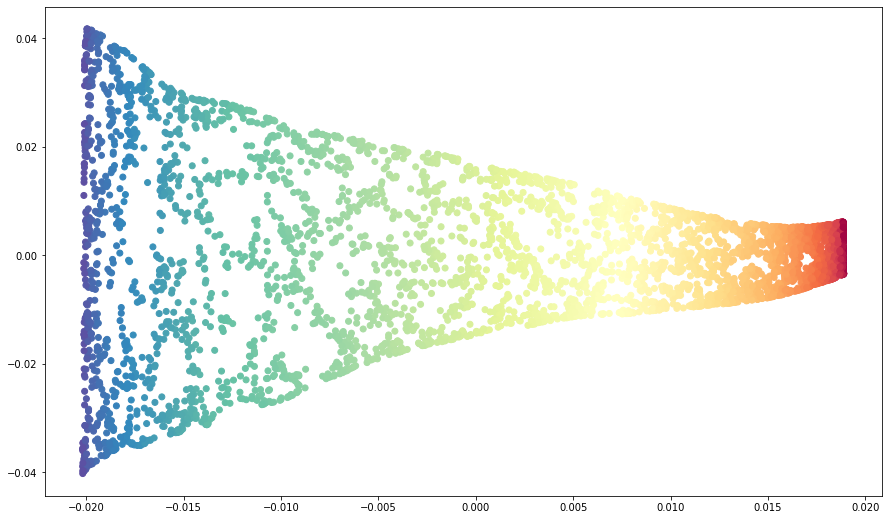

In [11]:
# simulate datafold
process_via_datafold()

# Part 3

In [12]:
def part_3():
    a = read_text('data_DMAP_PCA_vadere.txt')
    diffusion_map_a = DiffusionMap(data=a, L=10)
    visualize_eigenfunctions(diffusion_map_a)

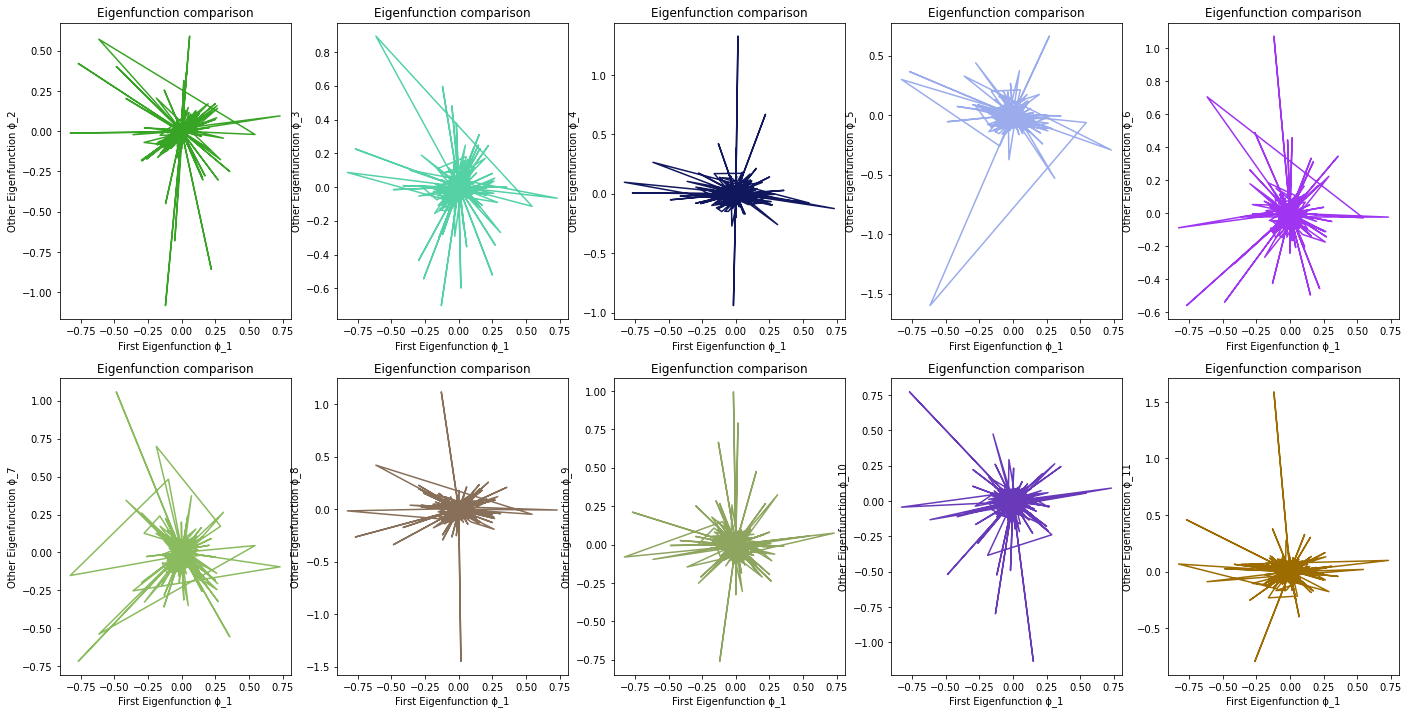

In [13]:
part_3()